## Init

In [29]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot
import re
import os
plt = pyplot

os.chdir('neurohack-2016-starterkit/task_3/')

## TensorFlow PearsonR implementation

In [3]:
def pearsonr(x, y):
    mx, sx = tf.nn.moments(x, [1])
    my, sy = tf.nn.moments(y, [1])
    
    sigma_x = tf.sqrt(sx)
    sigma_y = tf.sqrt(sy)

    return tf.reduce_mean((tf.reduce_mean(x * y, 1) - mx * my) / sigma_x / sigma_y, 1)
    
def diff(x):
    return tf.slice(x, [0, 1, 0], [-1, -1, -1]) - tf.slice(x, [0, 0, 0], tf.shape(x) - [0, 1, 0])

## Model graph

In [231]:
num_subjects = 3
input_size = 8
output_size = 2
num_units = 16
dtype = tf.float32

tf.reset_default_graph()

x = tf.placeholder(dtype = dtype, shape = (None, None, input_size), name = 'input')
subject = tf.placeholder(dtype = tf.int32, shape = (), name = 'subject')
y = tf.placeholder(dtype = dtype, shape = (None, None, output_size), name = 'output')
sequence_length = tf.placeholder(dtype = tf.int32, shape = (None), name = 'sequence_length')

batch_size = tf.shape(x)[0]

subject_onehot = tf.one_hot(subject, num_subjects)

with tf.variable_scope('rnn'):
    cell = tf.nn.rnn_cell.LSTMCell(num_units = num_units, num_proj = output_size)   
    init_state = cell.zero_state(batch_size, dtype = dtype)

subject_onehot = tf.tile(tf.reshape(subject_onehot, (1, 1, num_subjects)), (batch_size, tf.shape(x)[1], 1))

x_subject = tf.concat(2, [subject_onehot, x])

outputs, end_state = tf.nn.dynamic_rnn(cell, x_subject, initial_state = init_state, sequence_length = sequence_length)

r = tf.reduce_sum(tf.reduce_mean(pearsonr(diff(outputs), diff(y)), 0), name = 'loss_mean')
loss = -r
opt_op = tf.train.AdamOptimizer()
opt = opt_op.minimize(loss)

### Create session

In [238]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### Model saving/restoring

In [371]:
saver.restore(sess,'./model16_best.ckpt')

In [213]:
saver.save(sess,'./model_backup.ckpt')

'./model_backup.ckpt'

### Feed construction

In [360]:
def make_feed(trials):
    x_batch = []
    y_batch = []
    
    # Make batches
    for trial_name, trial_data in trials:
        x_batch.append(trial_data['emg'])
        y_batch.append(trial_data['pen_coordinates'])
        
    seq_length = [len(seq) for seq in x_batch]
    max_length = max(seq_length)

    # Padding just to make TF happy
    x_batch = np.array([np.pad(b,[[0, max_length - len(b)], [0,0]], 'constant') for b in x_batch])
    y_batch = np.array([np.pad(b,[[0, max_length - len(b)], [0,0]], 'constant') for b in y_batch])

    return {subject: subject_id, sequence_length: seq_length, x: x_batch, y: y_batch}

## Start training

In [372]:
train_io = h5py.File("train.h5")

inp = pd.DataFrame()

for epoch in range(1):
    prs = []
    for subject_name, subject_data in train_io.items():
        
        subject_id = re.findall(r'\d+', subject_name)[0]
        
        for d, digit_data in subject_data.items():

            trials = sorted(dict(digit_data).items())
            
            # Leave 5 trials for validation
            trials_in = trials[:-5]
            feed = make_feed(trials_in)

            # Do optimization step
            trials_out, values, _ = sess.run([outputs, y, opt], feed)
            #print(len(feed[sequence_length]))
            
            # Collect input
            for trial_in, trial_out, value, seq_length in zip(trials_in, trials_out, values, feed[sequence_length]):
      
                i = pd.DataFrame({'subject_id': subject_id, 'digit': d
                                , 'trial_id': re.findall(r'\d+', trial_in[0])[0]
                                , 'tick_index': range(seq_length)
                                , 'x': trial_out[:seq_length,0], 'y': trial_out[:seq_length,1]
                                , 'X': value[:seq_length,0], 'Y': value[:seq_length,1]})
                inp = pd.concat([inp, i]) 
            
            # Collect pearson values on validation trials
            feed = make_feed(trials[-5:])
            pr = sess.run(r, feed)
            prs.append(pr)

    if epoch % 10 == 0:
        print("Epoch %d, Pearson: min %f, max %f, mean %f" % (epoch, np.min(prs), np.max(prs), np.mean(prs)))
        saver.save(sess, "model_16_epoch_%s_1.ckpt" % epoch)

Epoch 0, Pearson: min 0.499150, max 0.958113, mean 0.827192


## Build test output

In [262]:
test_io = h5py.File("test.h5")

out = pd.DataFrame(columns = ['subject_id','trial_id','tick_index','x','y'])

for subject_name, subject_data in test_io.items():

    x_batch = []
    for trial_name, trial_data in subject_data.items():
        x_batch.append(trial_data)
                              
    seq_length = [len(seq) for seq in x_batch]
    max_length = max(seq_length)
   
    x_batch = np.array([np.pad(b,[[0, max_length - len(b)], [0,0]], 'constant') for b in x_batch])

    subject_id = re.findall(r'\d+', subject_name)[0]
    feed = {subject: subject_id, sequence_length: seq_length, x: x_batch}

    outs = sess.run(outputs, feed)

    for b, trial, length in zip(outs, subject_data.keys(), seq_length):
        o = pd.DataFrame({'subject_id': subject_id, 'trial_id': re.findall(r'\d+', trial)[0], 'tick_index': list(range(length)), 'x': b[:length,0], 'y': b[:length,1]})
        out = pd.concat([out, o]) 

## Plot sh*t

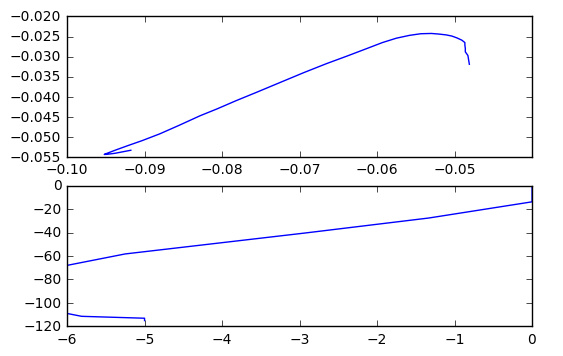

In [391]:
plot_data = inp[(inp['subject_id'] == '1') & (inp['digit'] == '1')]
plot_data = plot_data[plot_data['trial_id'] == plot_data.trial_id.unique()[30]]

plt.figure(1)
plt.subplot(211)
plt.plot(plot_data.x, plot_data.y)
plt.subplot(212)
plt.plot(plot_data.X, plot_data.Y)
#plt.ylim(-110,-106)

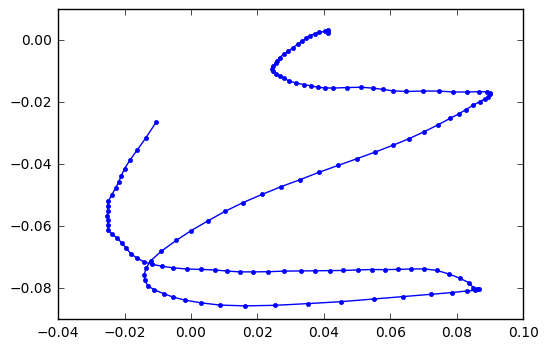

In [393]:
plot_data = out[out['subject_id'] == '2']
plot_data = plot_data[plot_data['trial_id'] == plot_data.trial_id.unique()[0]]
#plot_data = plot_data[plot_data['trial_id'] == '496']
plt.plot(plot_data.x, plot_data.y, marker = '.')

## Export CSV

In [264]:
out.to_csv('submission.csv', index = False, columns = ['subject_id','trial_id','tick_index','x','y'])